### Import libraries and dataset connection

In [1]:
import os, sys
from typing import List
from collections.abc import Callable

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator

In [4]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [5]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 15, 8.27
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.templates.default = 'seaborn'

In [6]:
from ipywidgets import interact, interact_manual, FloatSlider

In [7]:
sys.path.append(os.path.abspath('..'))

from src.utils import FILES, DATA_FOLDERS, extract_study_phase, load_dataset, fetch_data, preprocess, create_dataset, Preprocessor

CONNECTION_DIR = '/Users/arnauddhaene/Downloads/'

### Testing my implementation

In [8]:
labels, lesions, patients = fetch_data()

Post-1 study lesions extracted for 89 patients
Post-1 study labels added for 89 patients
The intersection of datasets showed 89 potential datapoints.


<AxesSubplot:ylabel='Count'>

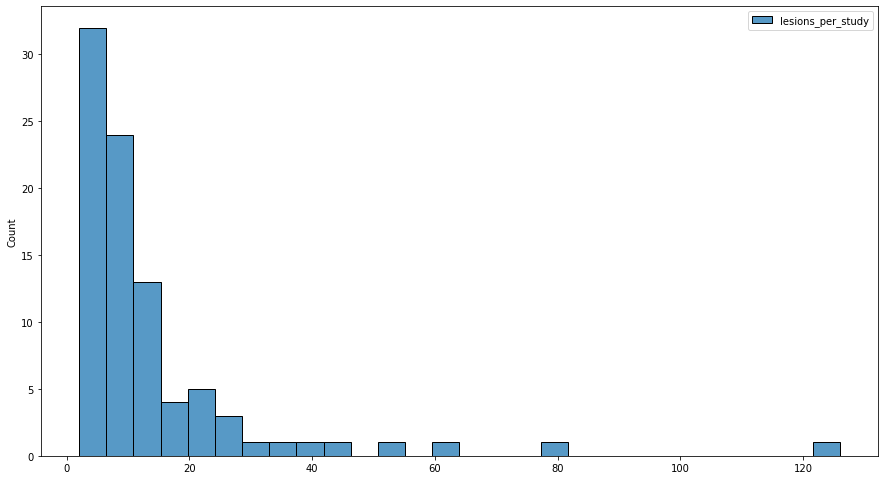

In [10]:
sns.histplot(lesions.groupby('gpcr_id').size().to_frame('lesions_per_study'))

In [59]:
seed = 27
test_size, val_size = 0.2, 0.2

I_train, I_test, y_train, y_test = \
    train_test_split(labels.index, labels, test_size=test_size, random_state=seed)

# Account for already taken up test size
val_size = val_size / (1 - test_size)
# Compute validation set indices
I_train, I_val, y_train, y_val = \
    train_test_split(I_train, y_train, test_size=val_size, random_state=seed)

lesions_pp = Preprocessor(
    pipe=ColumnTransformer(
        [('scaler', StandardScaler(), make_column_selector(dtype_include=np.number)),
         ('one-hot', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=[bool, object]))]),
    feats_out_fn=lambda c: c.transformers_[0][-1] + list(c.transformers_[1][1].categories_[0])
)

patients_numerical = list(patients.select_dtypes(np.number).columns)
patients_categorical = list(patients.select_dtypes([bool, object]).columns)
patients_categorical.remove('immuno_therapy_type')

features_range = list(range(len(patients_numerical) + len(patients_categorical) + 1))
bp = np.cumsum([len(patients_numerical), len(patients_categorical), 1])

clf_patients = Pipeline([
    ('imputers', ColumnTransformer([
        ('median', SimpleImputer(strategy='median'), patients_numerical),
        ('frequent', SimpleImputer(strategy='most_frequent'), patients_categorical)
    ], remainder='passthrough')),
    ('preprocess', ColumnTransformer([
        ('scaler', StandardScaler(), features_range[0:bp[0]]),
        ('one-hot', OneHotEncoder(handle_unknown='ignore'), features_range[bp[0]:bp[1]]),
        ('count-vec', CountVectorizer(analyzer=set), features_range[bp[1]:bp[2]][0])
    ], remainder='passthrough')),
])

patients_pp = Preprocessor(
    pipe=clf_patients,
    feats_out_fn=lambda c: (c.named_steps['imputers'].transformers_[0][2] \
                            + list(c.named_steps['preprocess'].transformers_[1][1].get_feature_names()) \
                            + c.named_steps['preprocess'].transformers_[2][1].get_feature_names())
)

In [11]:
lesions_pp.fit(lesions.loc[I_train])

lesions_train = lesions_pp.transform(lesions.loc[I_train])
lesions_val = lesions_pp.transform(lesions.loc[I_val])
lesions_test = lesions_pp.transform(lesions.loc[I_test])

patients_pp.fit(patients.loc[I_train])

patients_train = patients_pp.transform(patients.loc[I_train])
patients_val = patients_pp.transform(patients.loc[I_val])
patients_test = patients_pp.transform(patients.loc[I_test])

X_train = pd.merge(lesions_train, patients_train, left_index=True, right_index=True)
X_val = pd.merge(lesions_val, patients_val, left_index=True, right_index=True)
X_test = pd.merge(lesions_test, patients_test, left_index=True, right_index=True)

ValueError: Found unknown categories [True] in column 3 during transform

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(labels, lesions, patients)

Processed and split dataset into 
	 Train: 70 
	 Validation: 11 
	 Test: 21


In [14]:
X_raw = pd.merge(lesions, patients, left_index=True, right_index=True)
X_raw.dropna(inplace=True)

numerical = list(X_raw.select_dtypes(np.number).columns)
categorical = list(X_raw.select_dtypes([bool, object]).columns)
categorical.remove('immuno_therapy_type')

ct = ColumnTransformer([
            ('one-hot', OneHotEncoder(drop='if_binary'), categorical),
            ('count-vec', CountVectorizer(analyzer=set), 'immuno_therapy_type')
        ], remainder='passthrough')

X_raw = pd.DataFrame(ct.fit_transform(X_raw), index=X_raw.index,
                     columns=[*list(map(lambda s: s[3:], ct.transformers_[0][1].get_feature_names())), *ct.transformers_[1][1].get_feature_names(), *numerical])

In [15]:
@interact(feature=X_train.columns)
def show_distribution(feature: str = 'bmi'):
    fig, ax = plt.subplots(1, 4)
    
    sns.histplot(X_raw, x=feature, ax=ax[0])
    sns.histplot(X_train, x=feature, ax=ax[1])
    sns.histplot(X_val, x=feature, ax=ax[2])
    sns.histplot(X_test, x=feature, ax=ax[3])
    
    plt.show()

interactive(children=(Dropdown(description='feature', index=19, options=('vol_ccm', 'max_suv_val', 'mean_suv_v…

In [ ]:
loader_train, loader_val, loader_test = load_dataset(batch_size=8)

### Fetch data

In [ ]:
lesions = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES['lesions']))
lesions['study_phase'] = lesions.study_name.apply(extract_study_phase)
lesions = lesions[(lesions.pars_classification_petct != 'benign')]

progression = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1], FILES['progression']))

studies = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES['studies']))
studies.rename(columns={'is_malignant': 'malignant_lesions'}, inplace=True)
studies.drop(columns=['n_days_to_treatment_start', 'n_days_to_treatment_end'], inplace=True)

patients = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES['patients']))
patients['age_at_treatment_start_in_years'] = \
    patients.age_at_treatment_start_in_years.apply(lambda a: 90 if a == '90 or older' else int(a))

blood = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1], FILES['blood']))
blood.drop(columns=['n_days_to_treatment_start', 'n_days_to_treatment_end'], inplace=True)
blood.rename(columns={feature: feature.replace('-', '_') for feature in blood.columns}, inplace=True)

### Create DataFrame

Filter lesions

In [ ]:
lesions = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES['lesions']))
# Filter out benign lesions and non-post-1 studies
lesions = lesions[(lesions.pars_classification_petct != 'benign') & (lesions.study_name == 'post-01')]

# Keep only radiomics features
radiomics_features = ['vol_ccm', 'max_suv_val', 'mean_suv_val', 'min_suv_val', 'sd_suv_val']
lesions = lesions[['gpcr_id', 'study_name', *radiomics_features, 'assigned_organ']]

print(f'Post-1 study lesions extracted for {len(lesions.gpcr_id.unique())} patients')

progression = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1], FILES['progression']))
progression['prediction_score'] = progression.prediction_score.eq('NPD').mul(1)

# Add prediction score label from progression df
lesions = lesions.merge(progression[['gpcr_id', 'study_name', 'prediction_score']],
                        on=['gpcr_id', 'study_name'], how='inner')
lesions = lesions[lesions.prediction_score.notna()]
lesions.drop(columns='prediction_score', inplace=True)

print(f'Post-1 study labels added for {len(lesions.gpcr_id.unique())} patients')

Fetch patient-level information

In [ ]:
patients = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES['patients']))
patients['age_at_treatment_start_in_years'] = \
    patients.age_at_treatment_start_in_years.apply(lambda a: 90 if a == '90 or older' else int(a))

blood = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1], FILES['blood']))
blood.rename(columns={feature: feature.replace('-', '_') for feature in blood.columns}, inplace=True)
blood['immuno_therapy_type'] = blood.immuno_therapy_type \
    .apply(lambda t: ['ipi', 'nivo'] if t == 'ipinivo' else [t])

# Filter in the patient information that we want access to
patient_features = ['age_at_treatment_start_in_years']
blood_features = ['sex', 'bmi', 'performance_score_ecog', 'ldh_sang_ul', 'neutro_absolus_gl', 'eosini_absolus_gl', 
                 'leucocytes_sang_gl', 'NRAS_MUTATION', 'BRAF_MUTATION', 'immuno_therapy_type']

patients = patients[['gpcr_id', *patient_features]]
blood = blood[['gpcr_id', *blood_features]]

patients = patients.merge(blood, on='gpcr_id', how='inner')

Find out who could be a potential patient and split the patients into train-test datasets

In [ ]:
potential_patients = list(set(lesions.gpcr_id) & set(patients.gpcr_id))

progression.set_index('gpcr_id', inplace=True)
y = progression[progression.study_name == 'post-01'].loc[potential_patients].prediction_score

print(f'The intersection of datasets showed {len(potential_patients)} potential datapoints.')

In [ ]:
class Preprocessor:
    
    def __init__(self, clf, feature_callback: Callable) -> None:
        self.clf = clf
        self.feature_callback = feature_callback
        
    def get_feature_names(self) -> List[str]:
        return self.feature_callback(self.clf)
    
    def fit(self, df: pd.DataFrame) -> None:
        
        self.clf.fit(df) 
    
    def transform(self, df: pd.DataFrame, index: List = None, columns: List[str] = None) -> pd.DataFrame:
        
        if index == None:
            index = df.index
           
        if columns == None:
            columns = self.get_feature_names()
    
        return pd.DataFrame(self.clf.transform(df), index=index, columns=columns)

### Split the dataset into training and testing patients

In [ ]:
I_train, I_test, y_train, y_test = train_test_split(potential_patients, y, test_size=0.3, random_state=27)

In [ ]:
lesions.set_index('gpcr_id', inplace=True)
lesions.drop(columns=['study_name'], inplace=True)

patients.set_index('gpcr_id', inplace=True)

In [ ]:
lesions_pp = Preprocessor(
    clf=ColumnTransformer(
        [('scaler', StandardScaler(), make_column_selector(dtype_include=np.number)),
         ('one-hot', OneHotEncoder(), make_column_selector(dtype_include=object))]),
    feature_callback=lambda c: c.transformers_[0][-1] + list(c.transformers_[1][1].categories_[0])
)

lesions_pp.fit(lesions.loc[I_train])

lesions_train = lesions_pp.transform(lesions.loc[I_train])
lesions_test = lesions_pp.transform(lesions.loc[I_test])

In [ ]:
patients_numerical = list(patients.select_dtypes(np.number).columns)
patients_categorical = list(patients.select_dtypes(object).columns)
patients_categorical.remove('immuno_therapy_type')

features_range = list(range(len(patients_numerical) + len(patients_categorical) + 1))
bp = np.cumsum([len(patients_numerical), len(patients_categorical), 1])

clf_patients = Pipeline([
    ('imputers', ColumnTransformer([
        ('median', SimpleImputer(strategy='median'), patients_numerical),
        ('frequent', SimpleImputer(strategy='most_frequent'), patients_categorical)
    ], remainder='passthrough')),
    ('preprocess', ColumnTransformer([
        ('scaler', StandardScaler(), features_range[0:bp[0]]),
        ('one-hot', OneHotEncoder(drop='if_binary'), features_range[bp[0]:bp[1]]),
        ('count-vec', CountVectorizer(analyzer=set), features_range[bp[1]:bp[2]][0])
    ], remainder='passthrough')),
])

patients_pp = Preprocessor(
    clf=clf_patients,
    feature_callback=lambda c: c.named_steps['imputers'].transformers_[0][2] \
        + c.named_steps['imputers'].transformers_[1][2] \
        + c.named_steps['preprocess'].transformers_[2][1].get_feature_names()
)

patients_pp.fit(patients.loc[I_train])

patients_train = patients_pp.transform(patients.loc[I_train])
patients_test = patients_pp.transform(patients.loc[I_test])

In [ ]:
X_train = pd.merge(lesions_train, patients_train, left_index=True, right_index=True)
X_test = pd.merge(lesions_test, patients_test, left_index=True, right_index=True)

In [ ]:
@interact(feature=X_train.columns)
def show_distribution(feature: str = 'bmi'):
    fig, ax = plt.subplots(1, 2)
    
    sns.histplot(X_train, x=feature, ax=ax[0])
    sns.histplot(X_test, x=feature, ax=ax[1])
    
    plt.show()